<a href="https://colab.research.google.com/github/DeadLetterQueue/prettymaps/blob/main/PrettyMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install overpy
!pip install git+https://github.com/abey79/vsketch#egg=vsketch
!pip install git+https://github.com/DeadLetterQueue/prettymaps.git
!pip install vsketch
!mkdir ../prints
!mkdir ../assets
!mkdir ../assets/Permanent_Marker/
!wget -O ../assets/Permanent_Marker/PermanentMarker-Regular.ttf https://github.com/marceloprates/prettymaps/raw/main/assets/Permanent_Marker/PermanentMarker-Regular.ttf


In [1]:
# For local execution (does not require installing the library):
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

from prettymaps import *
import vsketch
import osmnx as ox
import matplotlib.font_manager as fm
from matplotlib import pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import *
from shapely.affinity import *
from shapely.ops import unary_union
import warnings
from matplotlib.patches import Ellipse, Polygon
import matplotlib.hatch
import matplotlib.pyplot as plt
from shapely.ops import polylabel

import overpy
import numpy as np
import geopandas as gpd
import shapely.geometry as geometry
from geopandas import GeoDataFrame, read_file
from shapely.ops import linemerge, unary_union, polygonize

In [3]:
def add_text2(ax,text_x,text_y,text,color='#2F3737',rotation=0,zorder=5,size=30):
  ax.text(
    text_x, text_y,
    text,
    color = color,
    rotation = rotation,
    zorder = zorder,
    fontproperties = fm.FontProperties(fname = '../assets/Permanent_Marker/PermanentMarker-Regular.ttf', size = size),
  )

def midpoint(p1, p2):
    return Point((p1[0]+p2[0])/2, (p1[1]+p2[1])/2)

def label_way(polygon,label,color='#2F3737',rotation=0,zorder=7,size=10):
  if polygon is not None:
    if isinstance(polygon,geometry.Polygon):
      if polygon.is_valid:
        label_loc = polylabel(polygon, tolerance=1)
        add_text2(ax,label_loc.x,label_loc.y,label,color=color,rotation=rotation,zorder=zorder,size=size)
      else:
        point = polygon.representative_point()
        add_text2(ax,point.x,point.y,label,color=color,rotation=rotation,zorder=zorder,size=size)
    elif len(polygon) == 2:
      point = midpoint(polygon[0], polygon[1])
      add_text2(ax,point.x,point.y,label,color=color,rotation=rotation,zorder=zorder,size=size)

def postprocessing(layers):
  return layers

def convert_way_to_polygon(way):
  node_array = []
  for node in way.nodes:
    x, y = np.stack (
            ox.project_gdf(GeoDataFrame(geometry=[Point((node.lat,node.lon)[::-1])], crs='EPSG:4326'))
            .geometry[0]
            .xy
    )
    node_array.append((x[0],y[0]))
  if len(node_array) > 2:
    return geometry.Polygon(node_array)
  if len(node_array) == 2:
    return node_array
  return None

def lable_ways(query,tags):
  api = overpy.Overpass()
  for tag in tags:
    query = 'area[name="{}"]->.searchArea; ('.format(query)
    query += 'way["{}"="{}"](area.searchArea);'.format(tag[0],tag[1])
    query += ');(._;>;);out body;'
    result = api.query(query)
    for way in result.ways:
      label = None
      if 'name' in way.tags:
        label = way.tags['name']
      elif 'ref' in way.tags:
        label = way.tags['ref']
      else:
        continue
      label_way(convert_way_to_polygon(way),label,zorder=8)

def get_all_golf_courses(location):
  api = overpy.Overpass()
  query = """
      area[name="{}"]->.searchArea;
      (
        way["leisure"="golf_course"](area.searchArea);
      );
      (._;>;);
      out body;
      """.format(location)
  return api.query(query)
      

def draw_course(query,course_name=None):
  api = overpy.Overpass()

  if course_name is None:
    course_name = query

  size = 12
  fig, ax = plt.subplots(figsize = (size,size), constrained_layout = True, dpi = 300)
  fig.patch.set_facecolor('#FFEDDF')

  layers = plot(
      query = query,
      title = query,
      ax = ax,
      postprocessing = postprocessing,
      buffer_dist = 40,
      layers = {
          'perimeter':          {},
          'grass':              {'tags': {'landuse': 'grass'}},
          'wood':               {'tags': {'natural': 'wood'}},
          'water':              {'tags': {'natural': [ 'water', 'bay', 'coastline' ]}},
          'stream':             {'tags': {'waterway': 'stream'}},
          'golf_course':        {'tags': {'leisure': 'golf_course'}},
          'golf_bunker':        {'tags': {'golf': 'bunker'}},
          'golf_fairway':       {'tags': {'golf': 'fairway'}},
          'golf_rough':         {'tags': {'golf': 'rough'}},
          'golf_green':         {'tags': {'golf': 'green'}},
          'golf_hole':          {'tags': {'golf': 'hole'}},
          'golf_tee':           {'tags': {'golf': 'tee'}},
          'golf_driving_range': {'tags': {'golf': 'driving_range'}},
      },
      drawing_kwargs = {
          'perimeter':             {'ec': '#FF0000',                  'lw': 0             , 'fill': False},
          'golf_course':           {'fc': '#DEF6C0', 'ec': '#64a38d', 'lw': 0, 'zorder': 0,},#               'hatch': 'O'},
          'grass':                 {'fc': '#CDEBB0', 'ec': '#CDEBB0', 'lw': 0, 'zorder': 1,               'hatch': 'ooo...'},
          'wood':                  {'fc': '#ADD19E', 'ec': '#93B685', 'lw': 0, 'zorder': 1,               'hatch': 'o.'},
          'water':                 {'fc': '#6CCFF6', 'ec': '#59adcf', 'lw': 0, 'zorder': 1},
          'stream':                {'fc': '#6CCFF6', 'ec': '#59adcf', 'lw': 0, 'zorder': 1},
          'golf_rough':            {'fc': '#C6E8A7', 'ec': '#B1DE89', 'lw': 0, 'zorder': 1,                'hatch': '......'},
          'golf_fairway':          {'fc': '#CDEBB0', 'ec': '#CDEBB0', 'lw': 0, 'zorder': 2},
          'golf_driving_range':    {'fc': '#AAE0CB', 'ec': '#EBD499', 'lw': 0, 'zorder': 2},
          'golf_green':            {'fc': '#AAE0CB', 'ec': '#AAE0CB', 'lw': 0, 'zorder': 4},
          'golf_bunker':           {'fc': '#F5E9C6', 'ec': '#F5E9C6', 'lw': 0, 'zorder': 4},
          'golf_tee':              {'fc': '#CDEBB0', 'ec': '#CDEBB0', 'lw': 0, 'zorder': 4},
          'golf_hole':             {'fc': '#FF0000', 'ec': '#FF0000', 'lw': 1, 'zorder': 7},
      },

      osm_credit = {'x': .02, 'y': -.05, 'color': '#2F3737'}
  )

  lable_ways(query,[('golf','hole')])

  xmin, xmax = ax.get_xlim()
  ymin, ymax = ax.get_ylim()
  dx, dy = xmax-xmin, ymax-ymin
  ax.set_xlim(xmin, xmax)
  ax.set_ylim(ymin, ymax)

  add_text2(ax,xmin+.02*dx, ymin-.05*dy,course_name)

  plt.savefig('/content/drive/MyDrive/GolfCourseMaps/prints/' + "".join([character for character in course_name if character.isalnum()]) + '.png')

/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.7/dist-packages/osmnx/utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated 

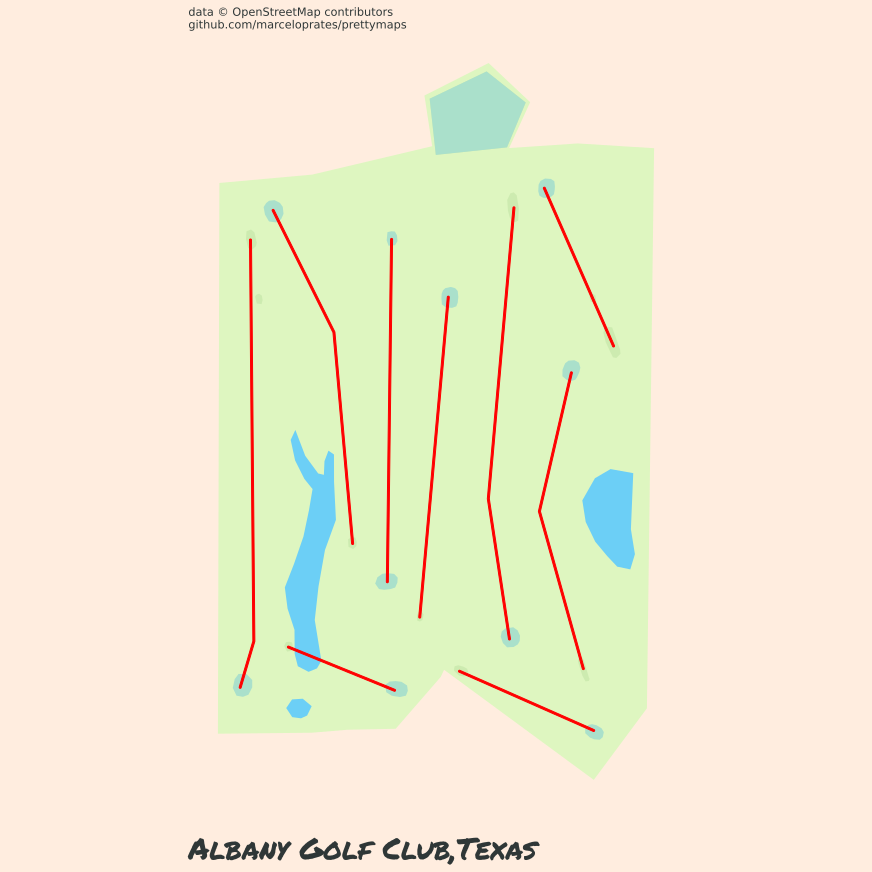

In [4]:
query = "Pebble Beach Golf Course"
query = 'Augusta National Golf Club'
query = 'Windyke Country Club'
query = 'Albany Golf Club,Texas'
draw_course(query)

In [ ]:
result = get_all_golf_courses('Texas')
for way in result.ways:
  print("Name: %s"    % way.tags.get("name", "n/a"))
  print("Highway: %s" % way.id)
  query = 'W{}'.format(way.id)
  name = way.tags.get("name", query)
  draw_course(query,course_name=name)


In [ ]:
import shutil
shutil.copytree('/prints/','/content/drive/MyDrive/GolfCourseMaps/prints')

'/content/drive/MyDrive/GolfCourseMaps/prints'

In [ ]:
import warnings
from matplotlib.patches import Ellipse, Polygon
import matplotlib.hatch
import matplotlib.pyplot as plt
from shapely.ops import polylabel
warnings.filterwarnings("ignore", category=DeprecationWarning)

fig, ax = plt.subplots(figsize = (24,24), constrained_layout = True, dpi = 300)
#fig, ax = plt.subplots(figsize = (3*3000/300, 3000/300), constrained_layout = True, dpi = 300)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html#matplotlib.pyplot.subplots
# https://github.com/matplotlib/matplotlib/blob/v3.5.1/lib/matplotlib/pyplot.py
# figsize = Width, height in inches of image
#     constrained_layout : bool, default: :rc:`figure.constrained_layout.use`
#        If ``True`` use constrained layout to adjust positioning of plot
#        elements.  Like ``tight_layout``, but designed to be more
#        flexible.  See
#        :doc:`/tutorials/intermediate/constrainedlayout_guide`
#        for examples.  (Note: does not work with `add_subplot` or
#        `~.pyplot.subplot2grid`.)

layer_to_label = {
  'golf_hole_1': '1st',
  'golf_hole_2': '2nd',
  'golf_hole_3': '3rd',
  'golf_hole_4': '4th',
  'golf_hole_5': '5th',
  'golf_hole_6': '6th',
  'golf_hole_7': '7th',
  'golf_hole_8': '8th',
  'golf_hole_9': '9th',
  'golf_hole_10': '10th',
  'golf_hole_11': '11th',
  'golf_hole_12': '12th',
  'golf_hole_13': '13th',
  'golf_hole_14': '14th',
  'golf_hole_15': '15th',
  'golf_hole_16': '16th',
  'golf_hole_17': '17th',
  'golf_hole_18': '18th',
}

def add_text2(ax,text_x,text_y,text,color='#2F3737',rotation=0,zorder=5,size=30):
  ax.text(
    text_x, text_y,
    text,
    color = color,
    rotation = rotation,
    fontproperties = fm.FontProperties(fname = '../assets/Permanent_Marker/PermanentMarker-Regular.ttf', size = size),
  )


house_path = Polygon(
    [[-0.3, -0.4], [0.3, -0.4], [0.3, 0.1]],
    closed=True, fill=False).get_path()

class CustomHatch(matplotlib.hatch.Shapes):
    """
    Custom hatches defined by a path drawn inside [-0.5, 0.5] square.
    Identifier 'c'.
    """
    filled = True
    size = 1.0
    path = house_path

    def __init__(self, hatch, density):
        self.num_rows = (hatch.count('c')) * density
        self.shape_vertices = self.path.vertices
        self.shape_codes = self.path.codes
        matplotlib.hatch.Shapes.__init__(self, hatch, density)

matplotlib.hatch._hatch_types.append(CustomHatch)

fig.patch.set_facecolor('#FFEDDF')

def label_polygons(polygons,label):
  try:
    iter(polygons)
    for polygon in polygons:
      label_way(polygon,label)
      print(polygon.length)
      print(label)
  except TypeError:
    label_way(polygons,label)

def label_way(polygon,label,color='#2F3737',rotation=0,zorder=7,size=10):
  if polygon is not None:
    if polygon.length > 2:
      print(polygon)
      label_loc = polylabel(polygon, tolerance=10)
      add_text2(ax,label_loc.x,label_loc.y,label,color=color,rotation=rotation,zorder=zorder,size=size)

def postprocessing(layers):
    #layers['perimeter'] = layers['perimeter'].buffer(100)
    for layer in layer_to_label:
      if layer in layers:
        layers[layer]
        label_polygons(layers[layer],layer_to_label[layer])
    return layers

#query = 'Glen View Club'
#query = 'Chick Evans Golf Course'
query = 'Albany Golf Club,Texas'
#query = ''
#query = 'Augusta National Golf Club'
#query = 'TPC Blue Monster'
#query = 'pebble beach'
#query = 'Spyglass Hill Golf Course'
#query = 'Cypress Point Golf Course'
#query = "Poppy Hills Golf Course"
query = "Pebble Beach Golf Course"
#query = 'R2709093'
#query = 'W28125487'
#query = 'Windyke Country Club'

import overpy
import numpy as np
import geopandas as gpd
import shapely.geometry as geometry
from geopandas import GeoDataFrame, read_file
from shapely.ops import linemerge, unary_union, polygonize
api = overpy.Overpass()

# fetch all ways and nodes
result = api.query("""
    area[name="{}"]->.searchArea;
(
way["golf"="hole"](area.searchArea);
);
(._;>;);
out body;
    """.format(query))

def convert_way_to_polygon(way):
  node_array = []
  for node in way.nodes:
    x, y = np.stack(
            ox.project_gdf(GeoDataFrame(geometry=[Point((node.lat,node.lon)[::-1])], crs=crs))
            .geometry[0]
            .xy
        )
    node_array.append((x[0],y[0]))
  print(node_array)
  if len(node_array) > 2:
    return geometry.Polygon(node_array)
  return None

for way in result.ways:
  label_way(convert_way_to_polygon(way),way.tags['name'],zorder=8)

'''for way in result.ways:
    print("Name: %s" % way.tags.get("name", "n/a"))
    print("ID: %s" % way.id)
    print("ID: %s" % way.nodes)
    print("ID: %s" % way.tags)
    print(convert_way_to_polygon(way))
    node_array = []
    lss = []
    for node in way.nodes:
      x, y = np.stack(
            ox.project_gdf(GeoDataFrame(geometry=[Point((node.lat,node.lon)[::-1])], crs=crs))
            .geometry[0]
            .xy
        )
      print(x)
      print(y)
      #point: Tuple, radius: float, crs: String, circle: Boolean = True, dilate: float = 0
      print(fetch.get_boundary((node.lat,node.lon),1,"EPSG:4326",False,0))
      label_polygons(fetch.get_boundary((node.lat,node.lon),1,"EPSG:4326",False,0),way.tags['name'])
      node_array.append((node.lat,node.lon))
    lss.append(geometry.LineString(node_array))
    print(lss[0].coords[0])
    merged = linemerge([*lss]) # merge LineStrings
    borders = unary_union(merged) # linestrings to a MultiLineString
    polygons = list(polygonize(lss[0]))
    print(polygons)
    label_polygons(polygons,way.tags['name'])
    #polygon_geom = Polygon(node_array)
    #crs = {'init': 'epsg:4326'}
    #print(node_array)
    #polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       
    #print(polygon.geometry)
    #polylabel(way.nodes, tolerance=10)'''



layers = plot(
    # City name
    #query = 'Albany, Texas',
    #(29.2948,-98.4787), radius = 500,
    #query = 'Mission Del Lago Golf Course',
    query = query,
    title = query,

    # Matplotlib 'ax'
    # https://github.com/matplotlib/matplotlib/blob/v3.5.1/lib/matplotlib/pyplot.py#L1363
    ax = ax,

    postprocessing = postprocessing,
    buffer_dist = 40,

    # Layers to plot & their kwargs
    # https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=geometries_from_polygon#osmnx.geometries.geometries_from_polygon
    layers = {
        'perimeter':          {},
        'grass':              {'tags': {'landuse': 'grass'}},
        'wood':               {'tags': {'natural': 'wood'}},
        'water':              {'tags': {'natural': 'water'}},
        'stream':             {'tags': {'waterway': 'stream'}},
        'golf_course':        {'tags': {'leisure': 'golf_course'}},
        'golf_bunker':        {'tags': {'golf': 'bunker'}},
        'golf_fairway':       {'tags': {'golf': 'fairway'}},
        'golf_rough':         {'tags': {'golf': 'rough'}},
        'golf_green':         {'tags': {'golf': 'green'}},
        'golf_hole':          {'tags': {'golf': 'hole'}},
        'golf_tee':           {'tags': {'golf': 'tee'}},
        'golf_driving_range': {'tags': {'golf': 'driving_range'}},
    },
    #https://matplotlib.org/stable/tutorials/intermediate/artists.html#customizing-your-objects
    drawing_kwargs = {
        'perimeter':             {'ec': '#FF0000',                  'lw': 0             , 'fill': False},
        'golf_course':           {'fc': '#DEF6C0', 'ec': '#64a38d', 'lw': 0, 'zorder': 0,               'hatch': 'O'},
        'grass':                 {'fc': '#CDEBB0', 'ec': '#CDEBB0', 'lw': 0, 'zorder': 1,               'hatch': 'ooo...'},
        'wood':                  {'fc': '#ADD19E', 'ec': '#93B685', 'lw': 0, 'zorder': 1,               'hatch': 'o.'},
        'water':                 {'fc': '#6CCFF6', 'ec': '#59adcf', 'lw': 0, 'zorder': 1},
        'stream':                {'fc': '#6CCFF6', 'ec': '#59adcf', 'lw': 0, 'zorder': 1},
        'golf_rough':            {'fc': '#C6E8A7', 'ec': '#B1DE89', 'lw': 0, 'zorder': 1,                'hatch': '......'},
        'golf_fairway':          {'fc': '#CDEBB0', 'ec': '#CDEBB0', 'lw': 0, 'zorder': 2},
        'golf_driving_range':    {'fc': '#AAE0CB', 'ec': '#EBD499', 'lw': 0, 'zorder': 2},
        'golf_green':            {'fc': '#AAE0CB', 'ec': '#AAE0CB', 'lw': 0, 'zorder': 4},
        'golf_bunker':           {'fc': '#F5E9C6', 'ec': '#F5E9C6', 'lw': 0, 'zorder': 4},
        'golf_tee':              {'fc': '#CDEBB0', 'ec': '#CDEBB0', 'lw': 0, 'zorder': 4},
        'golf_hole':             {'fc': '#FF0000', 'ec': '#FF0000', 'zorder': 7, 'lw': 1},
    },

    osm_credit = {'x': .02, 'y': -.05, 'color': '#2F3737'}
    #osm_credit = {'x': -1, 'y': 1, 'color': '#2F3737'}
)
 
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
dx, dy = xmax-xmin, ymax-ymin
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)


add_text2(ax,xmin+.02*dx, ymin-.05*dy,query)
add_text2(ax,xmin, ymin,'D')
add_text2(ax,xmax, ymin,'C')
add_text2(ax,xmax, ymax,'B')
add_text2(ax,xmin, ymax,'A')

plt.savefig('../prints/' + query.replace(' ','_') + '.png')


In [ ]:
import warnings
from matplotlib.patches import Ellipse, Polygon
import matplotlib.hatch
import matplotlib.pyplot as plt
from shapely.ops import polylabel
warnings.filterwarnings("ignore", category=DeprecationWarning)

fig, ax = plt.subplots(figsize = (12,12), constrained_layout = True, dpi = 300)
#fig, ax = plt.subplots(figsize = (3*3000/300, 3000/300), constrained_layout = True, dpi = 300)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html#matplotlib.pyplot.subplots
# https://github.com/matplotlib/matplotlib/blob/v3.5.1/lib/matplotlib/pyplot.py
# figsize = Width, height in inches of image
#     constrained_layout : bool, default: :rc:`figure.constrained_layout.use`
#        If ``True`` use constrained layout to adjust positioning of plot
#        elements.  Like ``tight_layout``, but designed to be more
#        flexible.  See
#        :doc:`/tutorials/intermediate/constrainedlayout_guide`
#        for examples.  (Note: does not work with `add_subplot` or
#        `~.pyplot.subplot2grid`.)

layer_to_label = {
  'golf_hole_1': '1st',
  'golf_hole_2': '2nd',
  'golf_hole_3': '3rd',
  'golf_hole_4': '4th',
  'golf_hole_5': '5th',
  'golf_hole_6': '6th',
  'golf_hole_7': '7th',
  'golf_hole_8': '8th',
  'golf_hole_9': '9th',
  'golf_hole_10': '10th',
  'golf_hole_11': '11th',
  'golf_hole_12': '12th',
  'golf_hole_13': '13th',
  'golf_hole_14': '14th',
  'golf_hole_15': '15th',
  'golf_hole_16': '16th',
  'golf_hole_17': '17th',
  'golf_hole_18': '18th',
}

house_path = Polygon(
    [[-0.3, -0.4], [0.3, -0.4], [0.3, 0.1]],
    closed=True, fill=False).get_path()

class CustomHatch(matplotlib.hatch.Shapes):
    """
    Custom hatches defined by a path drawn inside [-0.5, 0.5] square.
    Identifier 'c'.
    """
    filled = True
    size = 1.0
    path = house_path

    def __init__(self, hatch, density):
        self.num_rows = (hatch.count('c')) * density
        self.shape_vertices = self.path.vertices
        self.shape_codes = self.path.codes
        matplotlib.hatch.Shapes.__init__(self, hatch, density)



matplotlib.hatch._hatch_types.append(CustomHatch)

fig.patch.set_facecolor('#FFEDDF')

def label_polygons(polygons,label):
  try:
    iter(polygons)
    for polygon in polygons:
      label_way(polygon,label)
      print(polygon.length)
      print(label)
  except TypeError:
    label_way(polygons,label)

def label_way(way,label):
  label_loc = polylabel(way, tolerance=10)
  ax.text(
      label_loc.x, label_loc.y,
      label,
      color = '#2F3737',
      fontproperties = fm.FontProperties(fname = '../assets/Permanent_Marker/PermanentMarker-Regular.ttf', size = 10),
      zorder = 6,
  )

def postprocessing(layers):
    layers['perimeter'] = layers['perimeter'].buffer(10)
    for layer in layer_to_label:
      if layer in layers:
        layers[layer]
        label_polygons(layers[layer],layer_to_label[layer])
    return layers

#query = 'Glen View Club'
#query = 'Chick Evans Golf Course'
query = 'Albany Golf Club,Texas'
#query = ''
#query = 'Augusta National Golf Club'
#query = 'TPC Blue Monster'
#query = 'pebble beach'
#query = 'Spyglass Hill Golf Course'
#query = 'Cypress Point Golf Course'
#query = "Poppy Hills Golf Course"
query = "Pebble Beach Golf Course"
#query = 'R2709093'
#query = 'W28125487'
#query = 'Windyke Country Club'
layers = plot(
    # City name
    #query = 'Albany, Texas',
    #(29.2948,-98.4787), radius = 500,
    #query = 'Mission Del Lago Golf Course',
    query = query,
    title = query,

    # Matplotlib 'ax'
    # https://github.com/matplotlib/matplotlib/blob/v3.5.1/lib/matplotlib/pyplot.py#L1363
    ax = ax,

    postprocessing = postprocessing,

    # Layers to plot & their kwargs
    # https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=geometries_from_polygon#osmnx.geometries.geometries_from_polygon
    layers = {
        'perimeter': {},
        'grass':        {'tags': {'landuse': 'grass'}},
        'wood':         {'tags': {'natural': 'wood'}},
        'water':        {'tags': {'natural': 'water'}},
        'stream':       {'tags': {'waterway': 'stream'}},
        'golf':         {'tags': {'leisure': 'golf_course'}},
        'golf_sandtrap':{'tags': {'golf': 'bunker','natural':'sand'}},
        'golf_fairway': {'tags': {'golf': 'fairway'}},
        'golf_rough':   {'tags': {'golf': 'rough'}},
        'golf_green':   {'tags': {'golf': 'green'}},
        'golf_hole_1':  {'tags': {'ref': '1'}},
        'golf_hole_2':  {'tags': {'ref': '2'}},
        'golf_hole_3':  {'tags': {'ref': '3'}},
        'golf_hole_4':  {'tags': {'ref': '4'}},
        'golf_hole_5':  {'tags': {'ref': '5'}},
        'golf_hole_6':  {'tags': {'ref': '6'}},
        'golf_hole_7':  {'tags': {'ref': '7'}},
        'golf_hole_8':  {'tags': {'ref': '8'}},
        'golf_hole_9':  {'tags': {'ref': '9'}},
        'golf_hole_10':  {'tags': {'ref': '10'}},
        'golf_hole_11':  {'tags': {'ref': '11'}},
        'golf_hole_12':  {'tags': {'ref': '12'}},
        'golf_hole_13':  {'tags': {'ref': '13'}},
        'golf_hole_14':  {'tags': {'ref': '14'}},
        'golf_hole_15':  {'tags': {'ref': '15'}},
        'golf_hole_16':  {'tags': {'ref': '16'}},
        'golf_hole_17':  {'tags': {'ref': '17'}},
        'golf_hole_18':  {'tags': {'ref': '18'}},
        'golf_hole':    {'tags': {'golf': 'hole'}},
        'golf_tee':     {'tags': {'golf': 'tee'}},
        'golf_cartpath':{'tags': {'golf': 'cartpath'}},
        'golf_driving_range': {'tags': {'golf': 'driving_range'}},
    },
    #https://matplotlib.org/stable/tutorials/intermediate/artists.html#customizing-your-objects
    drawing_kwargs = {
        'perimeter':    {'ec': '#0F110C', 'fill': False, 'lw': 0},
        'park':         {'fc': '#AAD897', 'ec': '#8bc49e', 'lw': 0, 'zorder': 1},
        'grass':        {'fc': '#CDEBB0', 'ec': '#CDEBB0', 'lw': 0, 'zorder': 1, 'hatch': 'ooo...'},
        'wood':         {'fc': '#ADD19E', 'ec': '#93B685', 'lw': 0, 'zorder': 3, 'hatch': 'o.'},
        'wetland':      {'fc': '#D2D68D', 'ec': '#AEB441', 'lw': 0, 'zorder': 3},
        'water':        {'fc': '#6CCFF6', 'ec': '#59adcf', 'lw': 0, 'zorder': 4},
        'stream':       {'fc': '#6CCFF6', 'ec': '#59adcf', 'lw': 0, 'zorder': 2},
        'beach':        {'fc': '#F2E3BC', 'ec': '#EBD499', 'lw': 0, 'zorder': 2},
        'pedestrian':   {'fc': '#7BC950', 'ec': '#638475', 'lw': 0, 'zorder': 2},
        'streets':      {'fc': '#DDCCAA', 'ec': '#706f6f', 'zorder': -1, 'lw': 0},
        'golf_cartpath':{'fc': '#DDCCAA', 'ec': '#DDCCAA', 'zorder': 0, 'lw': 1,'fill':False},
        'golf_hole_1':  {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole_2':  {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole_3':  {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole_4':  {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole_5':  {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole_6':  {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole_7':  {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole_8':  {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole_9':  {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole_10': {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole_11': {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole_12': {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole_13': {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole_14': {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole_15': {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole_16': {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole_17': {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole_18': {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 5, 'lw': 1},
        'golf_hole':    {'fc': '#A1AD93', 'ec': '#A1AD93', 'zorder': 7, 'lw': 1},
        'golf':         {'fc': '#DEF6C0', 'ec': '#64a38d', 'lw': 0, 'zorder': 1},
        'golf_sandtrap':{'fc': '#F5E9C6', 'ec': '#F5E9C6', 'lw': 0, 'zorder': 4},
        'golf_fairway': {'fc': '#CDEBB0', 'ec': '#CDEBB0', 'lw': 0, 'zorder': 3},
        'golf_green':   {'fc': '#AAE0CB', 'ec': '#AAE0CB', 'lw': 0, 'zorder': 4},
        'golf_tee':     {'fc': '#AAE0CB', 'ec': '#AAE0CB', 'lw': 0, 'zorder': 4},
        'golf_driving_range':   {'fc': '#AAE0CB', 'ec': '#EBD499', 'lw': 0, 'zorder': 2},
        'golf_rough':   {'fc': '#C6E8A7', 'ec': '#B1DE89', 'lw': 0, 'zorder': 2, 'hatch': '......'},
        #'building':     {'palette': ['#FFC857', '#E9724C', '#C5283D'], 'ec': '#2F3737', 'lw': .5, 'zorder': 4,'label':'A'},
    },

    osm_credit = {'x': .02, 'y': -.05, 'color': '#2F3737'}
    #osm_credit = {'x': -1, 'y': 1, 'color': '#2F3737'}
)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
dx, dy = xmax-xmin, ymax-ymin
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.text(
    xmin+.02*dx, ymin-.05*dy,
    query,
    color = '#2F3737',
    #rotation = 90,
    fontproperties = fm.FontProperties(fname = '../assets/Permanent_Marker/PermanentMarker-Regular.ttf', size = 30),
)

ax.text(
    xmin, ymin,
    'd',
    color = '#FFC857',
    #rotation = 90,
    fontproperties = fm.FontProperties(fname = '../assets/Permanent_Marker/PermanentMarker-Regular.ttf', size = 30),
)

ax.text(
    xmax, ymax,
    'b',
    color = '#FFC857',
    #rotation = 90,
    fontproperties = fm.FontProperties(fname = '../assets/Permanent_Marker/PermanentMarker-Regular.ttf', size = 30),
)

ax.text(
    xmin, ymax,
    'a',
    color = '#FFC857',
    #rotation = 90,
    fontproperties = fm.FontProperties(fname = '../assets/Permanent_Marker/PermanentMarker-Regular.ttf', size = 30),
)

ax.text(
    xmax, ymin,
    'c',
    color = '#FFC857',
    #rotation = 90,
    fontproperties = fm.FontProperties(fname = '../assets/Permanent_Marker/PermanentMarker-Regular.ttf', size = 30),
)

plt.savefig('../prints/' + query.replace(' ','_') + '.png')

In [ ]:
import overpy
api = overpy.Overpass()

# fetch all ways and nodes
result = api.query("""
    area[name="Texas"]->.searchArea;
(
way["leisure"="golf_course"](area.searchArea);
);
(._;>;);
out body;
    """)
for way in result.ways:
    print("Name: %s" % way.tags.get("name", "n/a"))
    print("ID: %s" % way.id)
    
    fig, ax = plt.subplots(figsize = (12,12), constrained_layout = True, dpi = 300)

    fig.patch.set_facecolor('#FFEDDF')

    def postprocessing(layers):
        layers['perimeter'] = layers['perimeter'].buffer(10)
        return layers

    query = 'W' + str(way.id)
    name = way.tags.get("name", "n/a")

    layers = plot(
        query = query,
        ax = ax,
        postprocessing = postprocessing,
        
        layers = {
            'perimeter': {},
            'streets':     {
                'truncate_by_edge': False,
                'width': {
                    'motorway':     3,
                    'trunk':        3,
                    'primary':      3,
                    'secondary':    3,
                    'tertiary':     3,
                    'residential':  3,
                    'service':      3,
                    'path':         3,
                    'driveway':     3,
                    'hole':         3
                }
            },
            'park':         {'tags': {'leisure': 'park', 'landuse': 'golf_course', 'landuse': 'meadow', 'leisure': 'nature_reserve', 'boundary': 'protected_area', 'place': 'square', 'natural': 'grassland', 'landuse': 'military', 'amenity': 'hospital'}},
            'grass':        {'tags': {'landuse': 'grass'}},
            'wood ':        {'tags': {'natural': 'wood'}},
            'wetland':      {'tags': {'natural': 'wetland', 'natural': 'scrub'}},
            'beach':        {'tags': {'natural': 'beach'}},
            'water':        {'tags': {'natural': 'water'}},
            'stream':       {'tags': {'waterway': 'stream'}},
            'golf':         {'tags': {'leisure': 'golf_course'}},
            'golf_sandtrap':{'tags': {'golf': 'bunker','natural':'sand'}},
            'golf_fairway': {'tags': {'golf': 'fairway'}},
            'golf_rough':   {'tags': {'golf': 'rough'}},
            'golf_green':   {'tags': {'golf': 'green'}},
            'golf_hole':    {'tags': {'golf': 'hole'}},
            'golf_tee':     {'tags': {'golf': 'tee'}},
            'golf_cartpath':{'tags': {'golf': 'cartpath'}},
            'golf_driving_range': {'tags': {'golf': 'driving_range'}},
            'pedestrian':   {'tags': {'area:highway': 'pedestrian'}},
        },
        drawing_kwargs = {
            'perimeter':    {'fc': '#AAD897', 'ec': '#8bc49e', 'lw': 0, 'zorder': 1},
            'grass':        {'fc': '#72C07A', 'ec': '#64a38d', 'lw': 0, 'zorder': 1, 'hatch': 'ooo...'},
            'wood':         {'fc': '#ADD19E', 'ec': '#93B685', 'lw': 0, 'zorder': 1, 'hatch': 'O.'},
            'wetland':      {'fc': '#D2D68D', 'ec': '#AEB441', 'lw': 0, 'zorder': 3},
            'water':        {'fc': '#6CCFF6', 'ec': '#59adcf', 'lw': 0, 'zorder': 2},
            'stream':       {'fc': '#6CCFF6', 'ec': '#59adcf', 'lw': 0, 'zorder': 2},
            'beach':        {'fc': '#F2E3BC', 'ec': '#EBD499', 'lw': 0, 'zorder': 2},
            'pedestrian':   {'fc': '#7BC950', 'ec': '#638475', 'lw': 0, 'zorder': 2},
            'golf_cartpath':{'fc': '#DDCCAA', 'ec': '#DDCCAA', 'zorder': 3, 'lw': 1,'fill':False},
            'golf_hole':    {'fc': '#A1AD93', 'ec': '#706f6f', 'zorder': 3, 'lw': 0},
            'golf':         {'fc': '#DEF6C0', 'ec': '#64a38d', 'lw': 0, 'zorder': 1},
            'golf_sandtrap':{'fc': '#F5E9C6', 'ec': '#EBD499', 'lw': 0, 'zorder': 3},
            'golf_fairway': {'fc': '#CDEBB0', 'ec': '#EBD499', 'lw': 0, 'zorder': 2},
            'golf_green':   {'fc': '#AAE0CB', 'ec': '#EBD499', 'lw': 0, 'zorder': 3},
            'golf_tee':     {'fc': '#AAE0CB', 'ec': '#EBD499', 'lw': 0, 'zorder': 3},
            'golf_driving_range':   {'fc': '#AAE0CB', 'ec': '#EBD499', 'lw': 0, 'zorder': 2},
            'golf_rough':   {'fc': '#ADD19E', 'ec': '#EBD499', 'lw': 0, 'zorder': 2, 'hatch': 'ooo...'},
        },

        osm_credit = {'x': .02, 'y': -.05, 'color': '#2F3737'}
    )
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    dx, dy = xmax-xmin, ymax-ymin
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.text(
        xmin+.02*dx, ymin-.05*dy,
        name,
        color = '#2F3737',
        fontproperties = fm.FontProperties(fname = '../assets/Permanent_Marker/PermanentMarker-Regular.ttf', size = 30),
    )

    plt.savefig('../prints/' + query.replace(' ','_') + '.png')

